```
This notebook sets up and runs a test case for analyzing Kelvin waves
Copyright (C) 2018 - 2022 SINTEF Digital
Copyright (C) 2018 - 2022 Norwegian Meteorological Institute

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if (p.endswith("gpuocean/src") or p.endswith("gpuocean\\src"))][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

GPUOcean code from: 26b98e82e8d4e1ca2369cf735af8c7d3af460403 on branch reduced_gravity


# Sensitivy analysis of Boknafjorden

In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

from scipy.ndimage import gaussian_filter

# plt.rcParams["lines.color"] = "w"
# plt.rcParams["text.color"] = "w"
# plt.rcParams["axes.labelcolor"] = "w"
# plt.rcParams["xtick.color"] = "w"
# plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

In [3]:
from gpuocean.utils import IPythonMagic, NetCDFInitialization, WindStress, Observation
from gpuocean.SWEsimulators import CDKLM16
from gpuocean.dataassimilation import DataAssimilationUtils as dautils
from gpuocean.drifters import GPUDrifterCollection

In [4]:
%cuda_context_handler gpu_ctx

In [5]:
%cuda_context_handler barotropic_gpu_ctx

In [6]:
%cuda_context_handler baroclinic_gpu_ctx

Path to the test file

In [7]:
source_url = "/sintef/data/NorFjords160/A03/norfjords_160m_his.nc4_2019110101-2019110200"

## Inspecting file structure and content

In [8]:
import xarray as xr
ds = xr.open_dataset(source_url)
ds

<xarray.Dataset>
Dimensions:      (ocean_time: 24, s_rho: 35, s_w: 36, eta_rho: 801, xi_rho: 1161, eta_u: 801, xi_u: 1160, eta_v: 800, xi_v: 1161)
Coordinates:
  * ocean_time   (ocean_time) datetime64[ns] 2019-11-01T01:00:00 ... 2019-11-02
  * s_rho        (s_rho) float64 -0.9857 -0.9571 -0.9286 ... -0.04286 -0.01429
  * s_w          (s_w) float64 -1.0 -0.9714 -0.9429 ... -0.05714 -0.02857 0.0
    lon_rho      (eta_rho, xi_rho) float64 ...
    lat_rho      (eta_rho, xi_rho) float64 ...
    lon_u        (eta_u, xi_u) float64 ...
    lat_u        (eta_u, xi_u) float64 ...
    lon_v        (eta_v, xi_v) float64 ...
    lat_v        (eta_v, xi_v) float64 ...
Dimensions without coordinates: eta_rho, xi_rho, eta_u, xi_u, eta_v, xi_v
Data variables: (12/32)
    Vtransform   int32 ...
    Vstretching  int32 ...
    theta_s      float64 ...
    theta_b      float64 ...
    Tcline       float64 ...
    hc           float64 ...
    ...           ...
    u            (ocean_time, s_rho, eta_u, xi_u) float32 ...
    v            (ocean_time, s_rho, eta_v, xi_v) float32 ...
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt         (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    AKt          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
    AKs          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
Attributes:
    history:      Created by roms2nc4single.py from ROMS output file
    institution:  Institute of Marine Research
    type:         ROMS/TOMS history file
    title:        ROMS 3.5 - NorFjords
    svn_url:      https://www.myroms.org/svn/omlab/branches/kate
    code_dir:     /cluster/work/users/jonal/NorROMS/ROMS_src/official/ROMS_kate
    CPP_options:  NORFJORDS, ALBEDO, ATM_PRESS, ANA_BSFLUX, ANA_BTFLUX, ANA_S...

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  # Remove the CWD from sys.path while we load stuff.


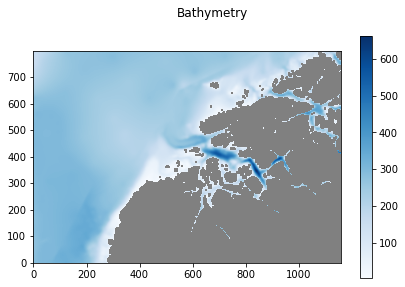

In [9]:
from netCDF4 import Dataset
nc = Dataset(source_url)

H_m = np.ma.array(nc["h"][1:-1,1:-1], mask=(1-nc["mask_rho"][1:-1,1:-1]))

fig, ax = plt.subplots()
fig.suptitle("Bathymetry")

cmap = plt.cm.Blues
cmap.set_bad("grey", alpha = 1.0)
im = ax.imshow(H_m, cmap=cmap)

plt.colorbar(im, ax=ax)
plt.tight_layout()

## Generating GPUOcean Simulation from Input

In [10]:
dimY, dimX = ds.h.data.shape
print(dimY, dimX)

801 1161


In [11]:
#x0, x1, y0, y1 = 685, dimX-375, 335, dimY-345

x0_shift = -0
y0_shift = -0
x0, x1, y0, y1 = 685+x0_shift, dimX-360, 335+y0_shift, dimY-330
print(y1-y0, x1-x0)

t=10
t_start = t
t_stop =  t_start + 6

T = (t_stop-t_start)*3600  #Input
timestep_indices = [list(np.arange(t_start, t_stop+1))]
print(timestep_indices)


136 116
[[10, 11, 12, 13, 14, 15, 16]]


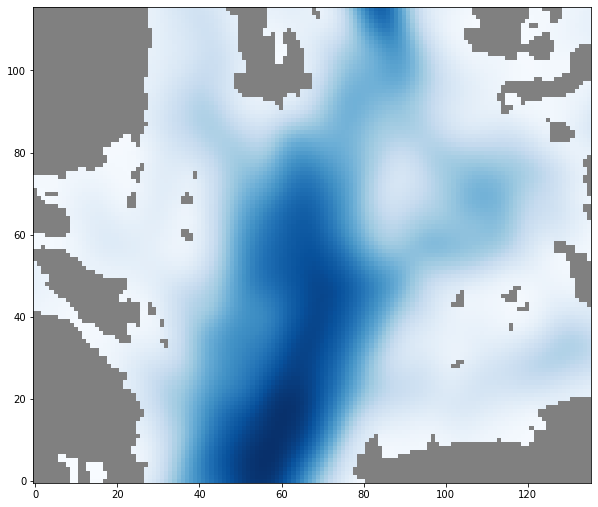

In [12]:
fig, ax = plt.subplots(figsize=(10,20))
ax.imshow(np.flip(np.ma.array(nc["h"][y0:y1, x0:x1], mask = 1-nc["mask_rho"][y0:y1,x0:x1]), axis=0).T, interpolation="none", cmap="Blues", origin="lower")

### Reference arguments and sims

In [13]:
try:
    ncfile = Dataset(source_url)
    H_full = np.array(ncfile.variables['h'])
    angle = np.array(ncfile.variables['angle'])
    print(H_full.shape)
    lat = np.array(ncfile.variables["lat_rho"])
    lon = np.array(ncfile.variables["lon_rho"])
except Exception as e:
    raise e
finally:
    ncfile.close()

spec_lat = lat[y0:y1, x0:x1]
spec_lon = lon[y0:y1, x0:x1]
spec_lon_levels = np.arange(5.42, 5.9, 0.2)
spec_lat_levels = np.arange(59.1, 59.4, 0.1)

print("min/max lon: ", spec_lon.min(), spec_lon.max())
print("min/max lat: ", spec_lat.min(), spec_lat.max())


#cont_lon_case = axs[0].contour(spec_lon, levels = np.arange(5.5, 5.9, lon_freq), extent=extent, colors='k', alpha=0.2, linewidths=0.8)
#cont_lat_case = axs[0].contour(spec_lat, levels = np.arange(58, 60, lat_freq), extent=extent, colors='k', alpha=0.2, linewidths=0.8)

(801, 1161)
min/max lon:  5.386881861730532 5.865366485009184
min/max lat:  59.09690728648659 59.32882625649319


In [14]:
from importlib import reload
reload(NetCDFInitialization)

<module 'gpuocean.utils.NetCDFInitialization' from '/home/florianb/havvarsel/gpuocean/src/gpuocean/utils/NetCDFInitialization.py'>

In [15]:
mld_density = 1023
sponge_cells = {'north': 5, 'south': 5, 'east': 5, 'west': 5}
ref_barotropic_data_args, ref_baroclinic_data_args = NetCDFInitialization.getCombinedInitialConditions(source_url, x0, x1, y0, y1, mld_density, timestep_indices=timestep_indices, norkyst_data=False, land_value=5.0, download_data=False, sponge_cells=sponge_cells)

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


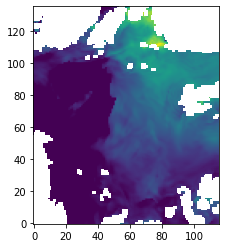

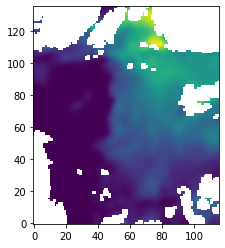

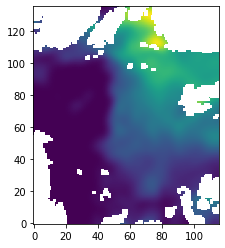

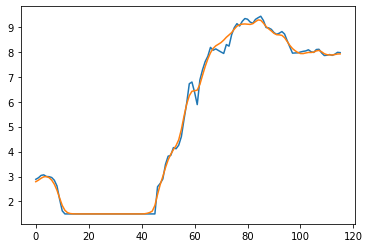

In [16]:
def smooth_mld(eta, sigma):
    if sigma > 0:
        smoothed_mld = gaussian_filter(eta.filled(0.0), sigma=sigma, mode="nearest")
        normaliser = gaussian_filter(np.ones_like(eta).filled(0.0), sigma=sigma, mode="nearest")   
        return np.ma.array(smoothed_mld/normaliser, mask=eta.mask)
    return eta

for sigma in [0, 1.5, 2.5]:
    fig = plt.figure()
    plt.imshow(smooth_mld(ref_baroclinic_data_args["eta0"], sigma), origin='lower')

fig = plt.figure()
for sigma in [0,  1]:
    tmp = smooth_mld(ref_baroclinic_data_args["eta0"], sigma)
    plt.plot(tmp[95, :])

In [17]:

smooth_sigma = 1.0
ref_baroclinic_data_args["eta0"] = smooth_mld(ref_baroclinic_data_args["eta0"], smooth_sigma)

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [17]:
ref_wind_stress_factor = 0.3
ref_baroclinic_data_args["wind_stress_factor"] = ref_wind_stress_factor
ref_windage = 0.01
print("friction: ", ref_baroclinic_data_args["r"], ref_barotropic_data_args["r"])
ref_wind = ref_baroclinic_data_args["wind"]


friction:  0.003 0.003


In [18]:
baroclinic_ref_sim = CDKLM16.CDKLM16(baroclinic_gpu_ctx, **NetCDFInitialization.removeMetadata(ref_baroclinic_data_args), dt=0.0, write_netcdf=False)
barotropic_ref_sim = CDKLM16.CDKLM16(barotropic_gpu_ctx, **NetCDFInitialization.removeMetadata(ref_barotropic_data_args), dt=0.0, write_netcdf=False)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


### Perturbations 

In [20]:
# MLD
mld_dens_samples = np.arange(1022.7, 1023.51, 0.05)
mld_samples_data_args = [None]*len(mld_dens_samples)
recompute_mld_data_args = False
if recompute_mld_data_args or mld_samples_data_args[0] is None:
    for i in range(len(mld_dens_samples)):
        _, mld_samples_data_args[i] = NetCDFInitialization.getCombinedInitialConditions(source_url, x0, x1, y0, y1, 
                                                                                        mld_dens_samples[i], timestep_indices=timestep_indices, norkyst_data=False, land_value=0.0, download_data=False)
        
        mld_samples_data_args[i]["eta0"] = smooth_mld(mld_samples_data_args[i]["eta0"], smooth_sigma)        
        print(mld_samples_data_args[i]["g"])
print(mld_dens_samples)

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


0.016356020790103842


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


0.01631143226963436


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


0.01625650896159362


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


0.016192204735512392


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


0.016120316271419976


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


0.016038358224976543


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


0.01594946811132094


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


0.015886586386370388


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


0.015815912644207737


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


0.015716248547024244


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


0.01559391584654915


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


0.015453410311035164


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


0.015292768048893787


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


0.015116274465810172


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


0.01492677271707644


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


0.01473578110954739
0.014555323273319437
[1022.7  1022.75 1022.8  1022.85 1022.9  1022.95 1023.   1023.05 1023.1
 1023.15 1023.2  1023.25 1023.3  1023.35 1023.4  1023.45 1023.5 ]


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [42]:
# Gravity
g_samples = [None]*len(mld_dens_samples)
for i in range(len(mld_dens_samples)):
    g_samples[i] = mld_samples_data_args[i]["g"]

g_extra_samples = np.arange(0.01, 0.11, 0.01)
print(ref_baroclinic_data_args["g"])


0.01594946811131876


In [43]:
# Wind 
def rotate_wind_field(wind, angle, plot=False):
    radians = (angle/360)*2*np.pi
    wind_u = wind.wind_u.copy()
    wind_v = wind.wind_v.copy()
    t = wind.t.copy()
    #print(t)

    c = np.cos(radians)
    s = np.sin(radians)
    wind_u_new = wind_u * c - wind_v * s
    wind_v_new = wind_u * s + wind_v * c

    if plot:
        x0, x1 = 200, 220
        y0, y1 = 200, 220

        fig = plt.figure()
        plt.quiver(wind_u[3, y0:y1, x0:x1], wind_v[3, y0:y1, x0:x1])

        fig = plt.figure()
        plt.quiver(wind_u_new[3, y0:y1, x0:x1], wind_v_new[3, y0:y1, x0:x1])
    return WindStress.WindStress(t=t, wind_u=wind_u_new, wind_v=wind_v_new)
       
#rotate_wind_field(ref_baroclinic_data_args['wind'], -45, plot=True)

wind_stress_samples = np.arange(0.0, 0.5, 0.05)
windage_samples = np.arange(0.0, 0.0525, 0.0025)

wind_directions = np.arange(-20, 21, 5)
wind_samples = [None]*len(wind_directions)
print(wind_directions)
for i in range(len(wind_directions)):
    wind_samples[i] = rotate_wind_field(ref_baroclinic_data_args["wind"], wind_directions[i])


[-20 -15 -10  -5   0   5  10  15  20]


In [44]:
# Friction
print("Reference friction coefficients for baroclinic and barotropic:", ref_baroclinic_data_args["r"], ref_barotropic_data_args["r"])
friction_samples = np.arange(0, 0.0055, 0.0005)
len(friction_samples)

Reference friction coefficients for baroclinic and barotropic: 0.003 0.003


11

#### Barotropic spread

In [45]:
# Barotropic data args by starting from earlier timesteps and doing a sufficient spin-up
# barotropic_spinup_data_args = []

# spinup_t = 24

# spinup_barotropic_data_args = NetCDFInitialization.getInitialConditions(source_url, x0, x1, y0, y1, timestep_indices=[np.arange(t_start-spinup_t, t_start+1)], norkyst_data=False, land_value=0.0, download_data=False)
# #spinup_barotropic_data_args.pop("wind")

# for wind_direction in wind_directions[::2]:
#     print(wind_direction)
#     #wind = WindStress.WindStress(t=[0], wind_u=[np.array([[np.cos(np.deg2rad(wind_direction))*10]]).astype(np.float32)], wind_v=[np.array([[np.sin(np.deg2rad(wind_direction))*10]]).astype(np.float32)])
#     spinup_barotropic_sim = CDKLM16.CDKLM16(gpu_ctx, **NetCDFInitialization.removeMetadata(spinup_barotropic_data_args), dt=0.0, wind=wind)
#     spinup_barotropic_sim.step(spinup_t*3600)
#     eta, hu, hv = spinup_barotropic_sim.download()

#     spunup_barotropic_data_args = copy.copy(ref_barotropic_data_args)
#     spunup_barotropic_data_args["eta0"] = eta
#     spunup_barotropic_data_args["hu0"] = hu
#     spunup_barotropic_data_args["hv0"] = hv
#     barotropic_spinup_data_args.append(spunup_barotropic_data_args)

In [46]:
barotropic_start_times = np.arange(0, 19, 3)
barotropic_time_shift_args = [None]*len(barotropic_start_times)
_, Hm = barotropic_ref_sim.downloadBathymetry()


for i in range(len(barotropic_start_times)):
    timestep_indices = [list(np.arange(barotropic_start_times[i], barotropic_start_times[i]+1))]
    barotropic_time_shift_args[i] = NetCDFInitialization.getInitialConditions(source_url, x0, x1, y0, y1, 
                                                                            timestep_indices=timestep_indices, 
                                                                            norkyst_data=False, land_value=5.0, download_data=False, 
                                                                            sponge_cells=sponge_cells)
    if i > 0 and False:
        fig = plt.figure()
        plt.imshow(barotropic_time_shift_args[i]["hu0"]/(barotropic_time_shift_args[i]["eta0"] + Hm) - \
                   barotropic_time_shift_args[0]["hu0"]/(barotropic_time_shift_args[0]["eta0"] + Hm), origin='lower')
        plt.colorbar()
    

In [47]:
Hi, Hm = barotropic_ref_sim.downloadBathymetry()
print(Hm.shape, Hi.shape)

(136, 116) (137, 117)


### Look at some of the initial distributions

In [48]:
# Barotropic spinup
# from gpuocean.utils import PlotHelper
# _, H_m = barotropic_ref_sim.downloadBathymetry()

# fig, axs = plt.subplots(1,len(barotropic_spinup_data_args),figsize=(5*len(barotropic_spinup_data_args),5))
# for i in range(len(barotropic_spinup_data_args)):
#     eta = barotropic_spinup_data_args[i]["eta0"]
#     hu  = barotropic_spinup_data_args[i]["hu0"]
#     hv  = barotropic_spinup_data_args[i]["hv0"]

#     V = PlotHelper.genVelocity(eta + H_m, hu, hv)
#     V.mask = eta.mask

#     # Colormaps
#     v_cmap=plt.cm.Oranges
#     v_cmap.set_bad('grey', alpha=1.0)

#     axs[i].imshow(V, cmap=v_cmap, vmin=0.0, vmax=0.1)

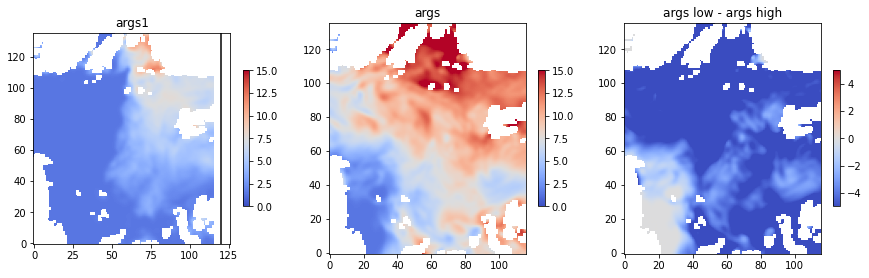

In [49]:
# MLD min vs max

fig, axs = plt.subplots(1,3, figsize=(15,5))

im = axs[0].imshow(mld_samples_data_args[0]["eta0"], vmin=0, vmax=15, cmap="coolwarm")
axs[0].set_title("args1")
plt.colorbar(im, ax=axs[0], shrink=0.5)

axs[0].axvline(x=120, c="black")

num_mld_samples = len(mld_samples_data_args)
im = axs[1].imshow(mld_samples_data_args[num_mld_samples-1]["eta0"], vmin=0, vmax=15, cmap="coolwarm")
axs[1].set_title("args")
plt.colorbar(im, ax=axs[1], shrink=0.5)

im = axs[2].imshow(mld_samples_data_args[0]["eta0"]-mld_samples_data_args[num_mld_samples-1]["eta0"], vmin=-5, vmax=5, cmap="coolwarm")
axs[2].set_title("args low - args high")
plt.colorbar(im, ax=axs[2], shrink=0.5)

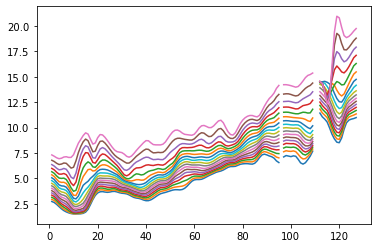

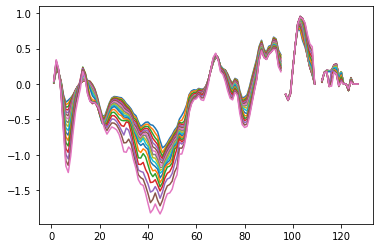

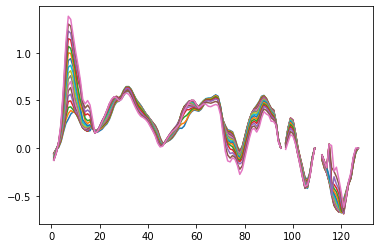

In [50]:
# MLD cross sections
y_cut = 75
plt.figure()
for i in range(len(mld_samples_data_args)):
    plt.plot(mld_samples_data_args[i]["eta0"][:, y_cut])

plt.figure()
for i in range(len(mld_samples_data_args)):
    plt.plot(mld_samples_data_args[i]["hu0"][:, y_cut])

plt.figure()
for i in range(len(mld_samples_data_args)):
    plt.plot(mld_samples_data_args[i]["hv0"][:, y_cut])



# Utility functions to run ensembles and plot variance and trajectories 

In [21]:
def run_sample(data_args_in, g=None, wind=None, wind_stress_factor=None, windage=0.0, friction=None, end_time=T, pert_init_drifter=False):
    data_args = copy.deepcopy(data_args_in)
    if g is not None:
        data_args["g"] = g
    if wind is not None:
        data_args["wind"] = wind
    if wind_stress_factor is not None:
        data_args["wind_stress_factor"] = wind_stress_factor
    if friction is not None:
        data_args["r"] = friction
    
    # Create sim
    sim = CDKLM16.CDKLM16(gpu_ctx, **NetCDFInitialization.removeMetadata(data_args),  dt=0.0)

    # Make observation object to log drift trajectory
    observation_type = dautils.ObservationType.UnderlyingFlow 
    observation_args = {'observation_type': observation_type,
                    'nx': sim.nx, 'ny': sim.ny,
                    'domain_size_x': sim.nx*sim.dx,
                    'domain_size_y': sim.ny*sim.dy,
                    'land_mask': sim.getLandMask()
                    }
    trajectories = Observation.Observation(**observation_args)

    # Create and initialize drifter objects
    initx = np.array([ 2500,  6000, 11000,  7500]) - 160*x0_shift
    inity = np.array([10000,  7500,  7000, 12000]) - 160*y0_shift
    num_drifters = len(initx)

    if pert_init_drifter:
        initx += np.random.normal(scale=100, size=num_drifters)
        inity += np.random.normal(scale=100, size=num_drifters)

    drifters = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, num_drifters,
                                                        boundaryConditions = sim.boundary_conditions,
                                                        domain_size_x = trajectories.domain_size_x,
                                                        domain_size_y = trajectories.domain_size_y,
                                                        gpu_stream = sim.gpu_stream,
                                                        wind=data_args["wind"],
                                                        wind_drift_factor = windage
                                                        )

    drifter_pos_init = np.array([initx, inity]).T
    drifters.setDrifterPositions(drifter_pos_init)

    # Attach drifters and log init position
    sim.attachDrifters(drifters)
    trajectories.add_observation_from_sim(sim)

    # Simulation loop, logging drifter positions every 2 min
    drifter_log_dt = 2*60
    t = 0
    while t < end_time:
        dt = min(drifter_log_dt, end_time - t)
        sim.step(dt)
        t = t + dt
        trajectories.add_observation_from_sim(sim)

    # return final ocean state and trajectory
    eta, hu, hv = sim.download()
    return {"eta": eta, "hu": hu, "hv": hv, "trajectories": trajectories}


In [22]:
baroclinic_ref_sim.nx, baroclinic_ref_sim.ny

(112, 132)

In [23]:

def _get_statistics(results, ref_sim):
    N = len(results)
    etas = np.zeros((N, results[0]["eta"].shape[0], results[0]["eta"].shape[1]))
    hus  = np.zeros((N, results[0]["hu"].shape[0],  results[0]["hu"].shape[1]))
    hvs  = np.zeros((N, results[0]["hv"].shape[0],  results[0]["hv"].shape[1]))
    for i in range(N):
        etas[i,:,:] = results[i]["eta"]
        hus[i,:,:] = results[i]["hu"]
        hvs[i,:,:] = results[i]["hv"]

    _, Hm = ref_sim.downloadBathymetry()


    v = np.sqrt((hus/(etas + Hm))**2 + (hvs/(etas + Hm))**2)

    mean_eta = np.ma.MaskedArray(np.mean(etas, axis=0), mask=results[0]["eta"].mask)
    mean_v   = np.ma.MaskedArray(np.mean(v,    axis=0), mask=results[0]["eta"].mask)
    var_eta  = np.ma.MaskedArray(np.var(etas,  axis=0), mask=results[0]["eta"].mask)
    var_v    = np.ma.MaskedArray(np.var(v,     axis=0), mask=results[0]["eta"].mask)


    return mean_eta, mean_v, var_eta, var_v


def _plot_field(results, field, ref_sim, T, title=None, plot_trajectories=True, 
                cmap=plt.cm.Reds, vmin=0.0, vmax=0.5, filename=None, cbar=True, cbar_label=None, zoom=[0,None,0,None],
                quiver=None, plot_drifter_init=False):
    
    with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
        fig, ax = plt.subplots(1,1, figsize=(7.5,7.5))#, figsize=(15,5))
        
        ax.tick_params(axis='both', which='major', labelsize=24)
        ax.set_xticks([0,5,10,15,20])
        ax.set_yticks([0,5,10,15,20])

        zoom_x0, zoom_x1, zoom_y0, zoom_y1 = zoom

        if zoom_x1 is None:
            dom_x1 = ref_sim.nx
        else:
            dom_x1 = zoom_x1
        if zoom_y1 is None:
            dom_y1 = ref_sim.ny
        else:
            dom_y1 = zoom_y1
        domain_extent = [zoom_x0*ref_sim.dx/1000, dom_x1*ref_sim.dx/1000, zoom_y0*ref_sim.dy/1000, dom_y1*ref_sim.dy/1000]

        cmap_cp = copy.copy(cmap)
        cmap_cp.set_bad("grey", alpha = 1.0)

        im = ax.imshow(field[zoom_y0:zoom_y1, zoom_x0:zoom_x1], interpolation="none", origin='lower', 
                       cmap=cmap_cp, 
                       vmin=vmin, vmax=vmax, 
                       extent=domain_extent)
        
        try:
            lat = np.array(nc.variables["lat_rho"])
            lon = np.array(nc.variables["lon_rho"])

            spec_lat = lat[y0:y1, x0:x1]
            spec_lon = lon[y0:y1, x0:x1]

            cont_lon_case = ax.contour(spec_lon, levels = np.arange(0, 30, 0.1), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8)
            cont_lat_case = ax.contour(spec_lat, levels = np.arange(30, 75, 0.1), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8)

        except Exception as e:
            raise e

        ax.tick_params(axis='both', which='major', labelsize=28)

        if plot_trajectories:
            num_drifters = results[0]["trajectories"].get_num_drifters()
            for d in range(num_drifters):
                for i in range(len(results)):
                    drifter_path = results[i]["trajectories"].get_drifter_path(d, 0, T, in_km = True)[0]
                    start_pos = drifter_path[0,:]

                    if (domain_extent[0] < start_pos[0] < domain_extent[1]) and (domain_extent[2] < start_pos[1] < domain_extent[3]):
                        circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                                        0.01, color = 'black',
                                                                        fill=True, zorder=10)
                        ax.add_patch(circ_start)
                        
                        drifter_pathX = np.minimum(np.maximum(domain_extent[0], drifter_path[:,0]),domain_extent[1])
                        drifter_pathY = np.minimum(np.maximum(domain_extent[2], drifter_path[:,1]),domain_extent[3])
                        ax.plot(drifter_pathX, drifter_pathY, color="C0", ls="-", zorder=5)
            
                        end_pos = drifter_path[-1,:]
                        if (domain_extent[0] < end_pos[0] < domain_extent[1]) and (domain_extent[2] < end_pos[1] < domain_extent[3]):
                            ax.scatter(end_pos[0], end_pos[1], marker='x', color='black', s=100, linewidths=2)

        if quiver is not None:
            ax.quiver(quiver[0], quiver[1], quiver[2], quiver[3], scale=5)

        if cbar:
            cb = plt.colorbar(im, ax=ax, shrink=0.75, pad=0.075) #, shrink=0.8)
            cb.ax.tick_params(labelsize=28)
            cb.formatter.set_powerlimits((-2, 2))
            cb.formatter.set_useMathText(True)
            cb.ax.yaxis.offsetText.set_fontsize(28)

        if cbar and cbar_label is not None:
            cb.set_label(label=cbar_label, size=24, labelpad=25)

        if plot_drifter_init:
            num_drifters = results[0]["trajectories"].get_num_drifters()
            for d in range(num_drifters):
                dummy_path = results[0]["trajectories"].get_drifter_path(d, 0, T, in_km = True)[0]
                start_pos = dummy_path[0,:]
                circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                        0.35, color = 'C9', linewidth=4,
                                                        fill=False, zorder=10)
                ax.add_patch(circ_start)

        if title is not None:
            plt.title(title+"\n", fontsize=16)
        
        plt.tight_layout()

        if filename is not None:
            folder = "boknafjord_sensitivity_figs"
            os.makedirs(folder, exist_ok=True)
            plt.savefig(os.path.join(folder, "bokna_"+filename+".pdf"), bbox_inches="tight", dpi=800)


def plot_drifters_and_variance(results, ref_sim, T, suptitle=None, filename=None, vmax=None, cbar=True, cbar_label=None, zoom=[0, None, 0, None]):
    # results are list with dicts [{eta, hu, hv, trajectories}]

    mean_eta, mean_vel, var_eta, var_vel = _get_statistics(results, ref_sim)

    if vmax is None:
        vmax = max(var_vel.max()/4, 1e-6)

    _plot_field(results, var_vel, ref_sim, T, title=suptitle, vmin=0, vmax=vmax, filename=filename, cbar=cbar, cbar_label=cbar_label,  zoom=zoom)
    #_plot_field(results, var_eta, ref_sim, T, "MLD variance", vmin=0, vmax=4)
    
    print("Maximum velocity: ", mean_vel.max(), var_vel.max())

#plot_drifters_and_variance(mld_dens_results, ref_sim, T, "Perturbing MLD init")

# Plot initial positions of the drifters with annotations

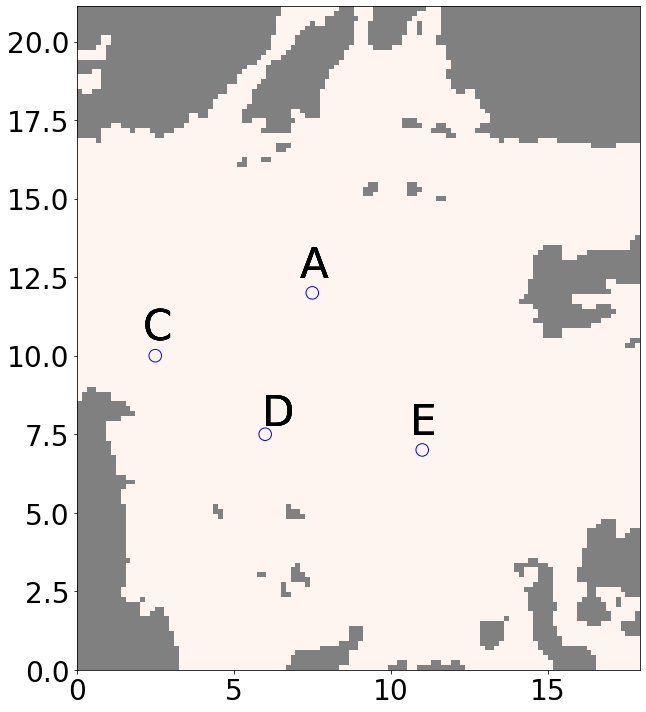

In [24]:
initx = np.array([ 2500,  6000, 11000,  7500]) - 160*x0_shift
inity = np.array([10000,  7500,  7000, 12000]) - 160*x0_shift

with plt.rc_context({'lines.color':'black', 
                    'text.color':'black', 
                    'axes.labelcolor':'black', 
                    'xtick.color':'black',
                    'ytick.color':'black'}):
    fig, ax = plt.subplots(1,1, figsize=(10,10))

    domain_extent = [0, barotropic_ref_sim.nx*barotropic_ref_sim.dx/1000,
                     0, barotropic_ref_sim.ny*barotropic_ref_sim.dy/1000]

    cmap_cp = copy.copy(plt.cm.Reds)
    cmap_cp.set_bad("grey", alpha = 1.0)
    background_field = np.zeros_like(ref_baroclinic_data_args["eta0"])

    im = ax.imshow(background_field, interpolation="none", origin='lower', 
                cmap=cmap_cp, 
                extent=domain_extent)
    
    ax.tick_params(axis='both', which='major', labelsize=28)

    for d in range(len(initx)):
        circ_start = matplotlib.patches.Circle((initx[d]/1000, inity[d]/1000), 
                                                0.2, color = 'blue',
                                                fill=False, zorder=10)
        ax.add_patch(circ_start)

        # plt.annotate("hei",(initx[0]-1, inity[0]+1))
        annotation_fontsize = 42
        ax.annotate("C",[initx[0]/1000-0.4, inity[0]/1000+0.5], fontsize=annotation_fontsize )
        ax.annotate("D",[initx[1]/1000-0.1, inity[1]/1000+0.3], fontsize=annotation_fontsize )
        ax.annotate("E",[initx[2]/1000-0.4, inity[2]/1000+0.5], fontsize=annotation_fontsize )
        ax.annotate("A",[initx[3]/1000-0.4, inity[3]/1000+0.5], fontsize=annotation_fontsize )

    # plt.title("Initial drifter positions\n", fontsize=16)
    plt.tight_layout()

    if True:
        folder = "boknafjord_sensitivity_figs"
        os.makedirs(folder, exist_ok=True)
        plt.savefig(os.path.join(folder, "initial_drifter_positions.pdf"), bbox_inches="tight")



# Run eperiments and plot results

Baroclinic reference

In [25]:
ref_baroclinic_result = [run_sample(ref_baroclinic_data_args)]

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


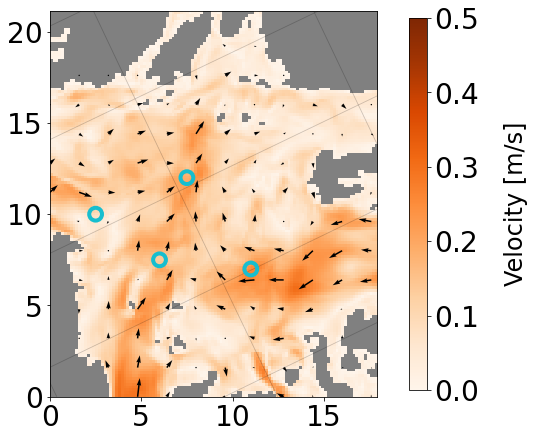

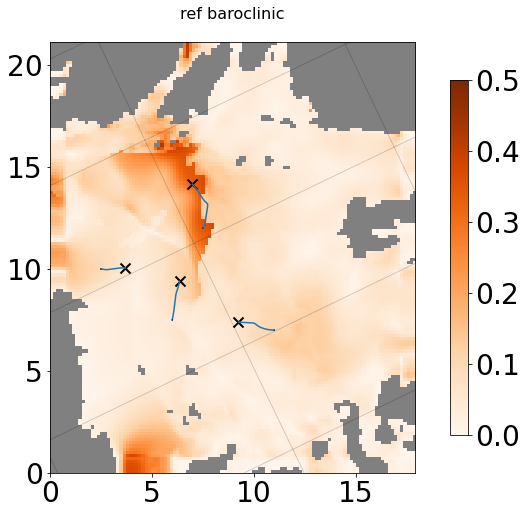

In [26]:
initV = np.ma.sqrt((ref_baroclinic_data_args["hu0"]/ref_baroclinic_data_args["eta0"])**2 + (ref_baroclinic_data_args["hv0"]/ref_baroclinic_data_args["eta0"])**2)

frequency_x = 10
frequency_y = 10
x = np.arange(0, initV.shape[1], frequency_x)*baroclinic_ref_sim.dx/1000
y = np.arange(0, initV.shape[0], frequency_y)*baroclinic_ref_sim.dy/1000
qu = (ref_baroclinic_data_args["hu0"]/ref_baroclinic_data_args["eta0"])[::frequency_y, ::frequency_x]
qv = (ref_baroclinic_data_args["hv0"]/ref_baroclinic_data_args["eta0"])[::frequency_y, ::frequency_x]

_plot_field(ref_baroclinic_result, initV, baroclinic_ref_sim, T, filename="init_baroclinic", plot_trajectories=False, cbar_label="Velocity [m/s]", cmap=plt.cm.Oranges, 
            quiver=[x,y,qu,qv], plot_drifter_init=True)


refV = np.ma.sqrt((ref_baroclinic_result[0]["hu"]/ref_baroclinic_data_args["eta0"])**2 + (ref_baroclinic_result[0]["hv"]/ref_baroclinic_data_args["eta0"])**2)
_plot_field(ref_baroclinic_result, refV, baroclinic_ref_sim, T, "ref baroclinic", plot_trajectories=True, cmap=plt.cm.Oranges)

Barotropic reference

In [27]:
ref_barotropic_result = [run_sample(ref_barotropic_data_args)]

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


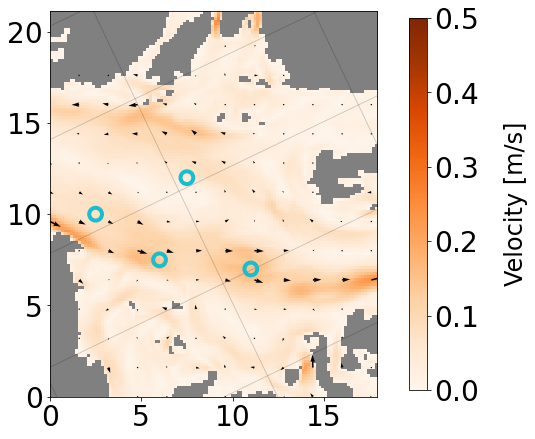

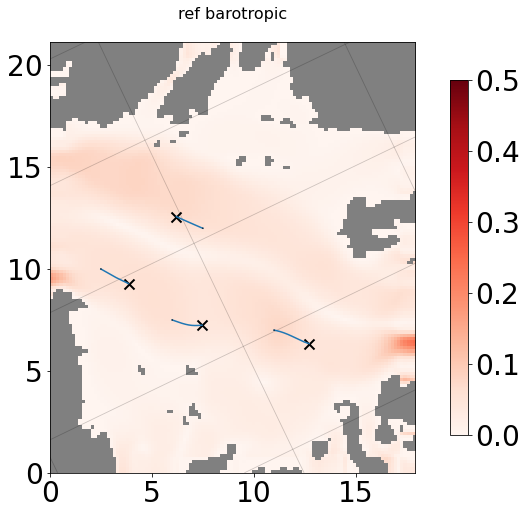

In [28]:
initV = np.ma.sqrt((ref_barotropic_data_args["hu0"]/Dataset(source_url)["h"][y0:y1, x0:x1])**2 + (ref_barotropic_data_args["hv0"]/Dataset(source_url)["h"][y0:y1, x0:x1])**2)

frequency_x = 10
frequency_y = 10
x = np.arange(0, initV.shape[1], frequency_x)*barotropic_ref_sim.dx/1000
y = np.arange(0, initV.shape[0], frequency_y)*barotropic_ref_sim.dy/1000
qu = (ref_barotropic_data_args["hu0"]/barotropic_ref_sim.downloadBathymetry()[1])[::frequency_y, ::frequency_x]
qv = (ref_barotropic_data_args["hv0"]/barotropic_ref_sim.downloadBathymetry()[1])[::frequency_y, ::frequency_x]

_plot_field(ref_barotropic_result, initV, barotropic_ref_sim, T, filename="init_barotropic", plot_trajectories=False, cbar_label="Velocity [m/s]", cmap=plt.cm.Oranges, 
            quiver=[x,y,qu,qv], plot_drifter_init=True)


refV = np.ma.sqrt((ref_barotropic_result[0]["hu"]/Dataset(source_url)["h"][y0:y1, x0:x1])**2 + (ref_barotropic_result[0]["hv"]/Dataset(source_url)["h"][y0:y1, x0:x1])**2)
_plot_field(ref_barotropic_result, refV, barotropic_ref_sim, T, "ref barotropic", plot_trajectories=True)

## Baroclinic

### MLD coupled with gravity

In [59]:
mld_dens_results = [None]*len(mld_dens_samples)
mld_dens_results_no_wind = [None]*len(mld_dens_samples)
for i in range(len(mld_dens_samples)):
    mld_dens_results[i] = run_sample(mld_samples_data_args[i], wind=ref_wind, wind_stress_factor=ref_wind_stress_factor, windage=ref_windage)
    mld_dens_results_no_wind[i] = run_sample(mld_samples_data_args[i])


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccura

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Maximum velocity:  0.3705020109279348 0.009158401261309153


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Maximum velocity:  0.3705020109279348 0.008123596294803595


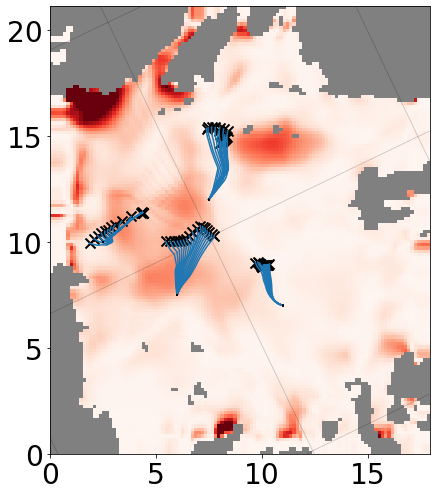

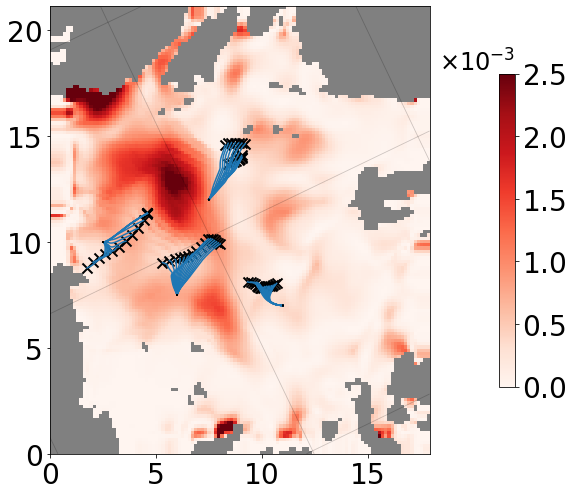

In [60]:
plot_drifters_and_variance(mld_dens_results, baroclinic_ref_sim, T, filename="mld_coupled_g", vmax=0.0025, cbar=False)
plot_drifters_and_variance(mld_dens_results_no_wind, baroclinic_ref_sim, T, filename="mld_coupled_g_nowind", vmax=0.0025)


### MLD decoupled from gravity

In [61]:
mld_init_same_g_results = [None]*len(mld_dens_samples)
mld_init_same_g_results_no_wind = [None]*len(mld_dens_samples)
for i in range(len(mld_dens_samples)):
    mld_init_same_g_results[i] = run_sample(mld_samples_data_args[i], ref_baroclinic_data_args["g"], wind=ref_wind, wind_stress_factor=ref_wind_stress_factor, windage=ref_windage)
    mld_init_same_g_results_no_wind[i] = run_sample(mld_samples_data_args[i], ref_baroclinic_data_args["g"])

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccura

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Maximum velocity:  0.3705065403549514 0.009913909990455643


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Maximum velocity:  0.3705065403549514 0.009122012342540337


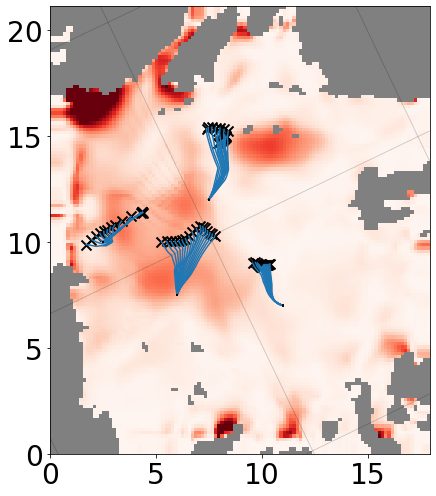

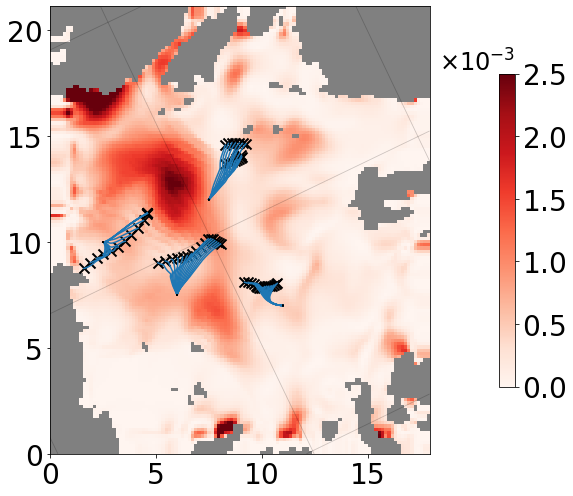

In [62]:
plot_drifters_and_variance(mld_init_same_g_results, baroclinic_ref_sim, T, filename="mld_decoupled_g", vmax=0.0025, cbar=False)
plot_drifters_and_variance(mld_init_same_g_results_no_wind, baroclinic_ref_sim, T, filename="mld_decoupled_g_nowind", vmax=0.0025)

### Reduced gravity constant, with g computed from different potential densities

In [63]:
g_results = [None]*len(mld_dens_samples)
g_results_no_wind = [None]*len(mld_dens_samples)
for i in range(len(mld_dens_samples)):
    g_results[i] = run_sample(ref_baroclinic_data_args, mld_samples_data_args[i]["g"], wind=ref_wind, wind_stress_factor=ref_wind_stress_factor, windage=ref_windage)
    g_results_no_wind[i] = run_sample(ref_baroclinic_data_args, mld_samples_data_args[i]["g"])


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccura

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Maximum velocity:  0.37164446718142585 0.0002611150849639046


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Maximum velocity:  0.37164446718142585 0.0002611150849639046


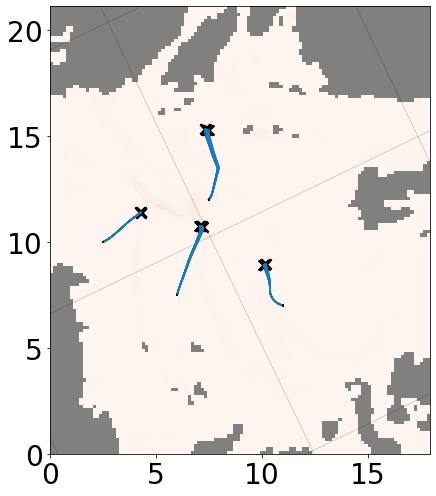

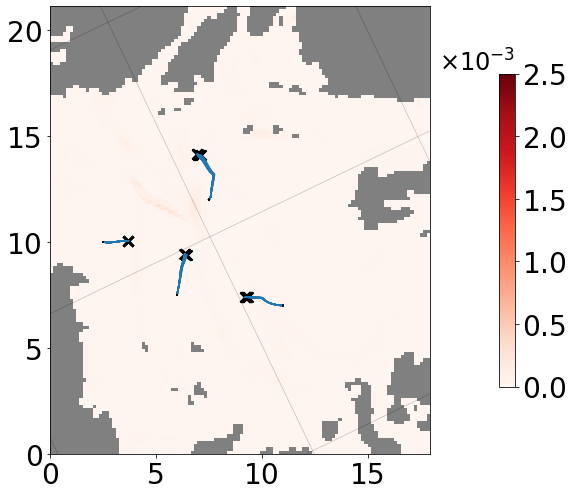

In [64]:
plot_drifters_and_variance(g_results, baroclinic_ref_sim, T, filename="g_decoupled_mdl", vmax=0.0025, cbar=False)
plot_drifters_and_variance(g_results_no_wind, baroclinic_ref_sim, T, filename="g_decoupled_mdl_nowind", vmax=0.0025)

### Reduced gravities, with g' sampled directly

In [65]:
g_results2 = [None]*len(g_extra_samples)
g_results2_no_wind = [None]*len(g_extra_samples)
for i in range(len(g_extra_samples)):
    g_results2[i] = run_sample(ref_baroclinic_data_args, g_extra_samples[i], wind=ref_wind, wind_stress_factor=ref_wind_stress_factor, windage=ref_windage)
    g_results2_no_wind[i] = run_sample(ref_baroclinic_data_args, g_extra_samples[i])


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccura

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Maximum velocity:  0.37164597628137575 0.01416988341960804


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Maximum velocity:  0.37164597628137575 0.01416988341960804


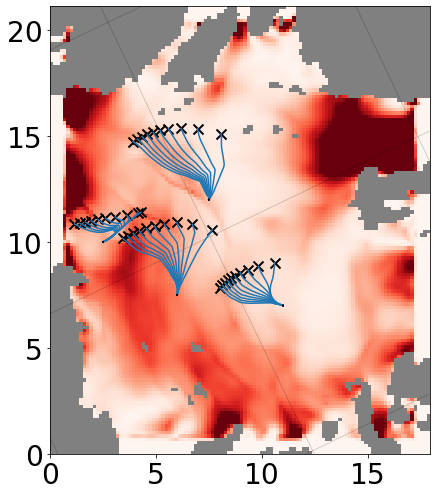

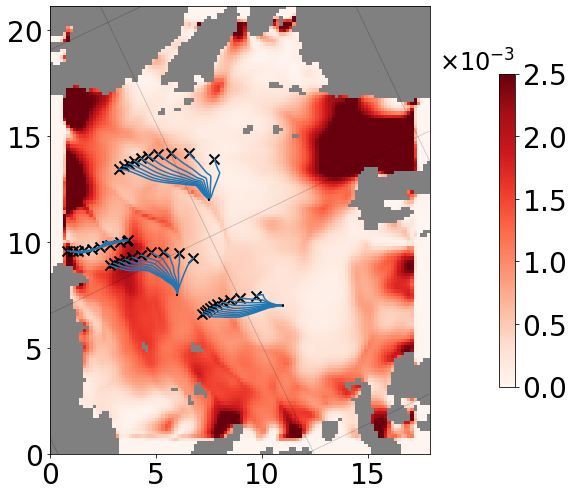

In [66]:
plot_drifters_and_variance(g_results2, baroclinic_ref_sim, T, filename="g", vmax=0.0025, cbar=False)
plot_drifters_and_variance(g_results2_no_wind, baroclinic_ref_sim, T, filename="g_nowind", vmax=0.0025)

### Wind direction

In [67]:
wind_direction_results = [None]*len(wind_samples)
wind_direction_results_no_windage = [None]*len(wind_samples)
for i in range(len(wind_samples)):
    wind_direction_results[i] = run_sample(ref_baroclinic_data_args, wind=wind_samples[i], wind_stress_factor=ref_wind_stress_factor, windage=ref_windage)
    wind_direction_results_no_windage[i] = run_sample(ref_baroclinic_data_args, wind=wind_samples[i], wind_stress_factor=ref_wind_stress_factor, windage=0)


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccura

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Maximum velocity:  0.3716409058000155 0.0005701383044137802


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Maximum velocity:  0.3716409058000155 0.0005701383044137802


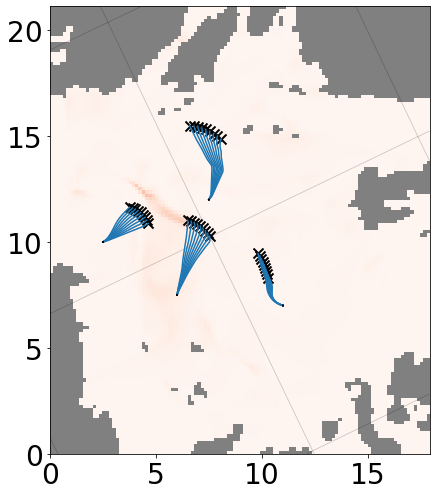

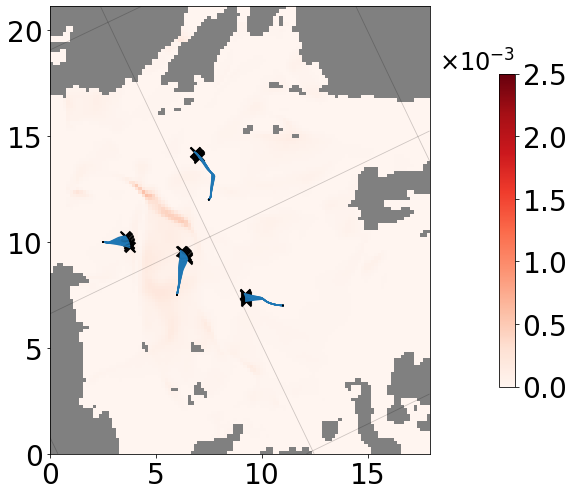

In [68]:
plot_drifters_and_variance(wind_direction_results, baroclinic_ref_sim, T, filename="wind_direction", vmax=0.0025, cbar=False)
plot_drifters_and_variance(wind_direction_results_no_windage, baroclinic_ref_sim, T, filename="wind_direction_nowindage", vmax=0.0025)


### Wind stress factor

In [69]:
wind_stress_results = [None]*len(wind_stress_samples)
wind_stress_results_no_windage = [None]*len(wind_stress_samples)
for i in range(len(wind_stress_samples)):
    wind_stress_results[i] = run_sample(ref_baroclinic_data_args, wind=ref_wind, wind_stress_factor=wind_stress_samples[i], windage=ref_windage)
    wind_stress_results_no_windage[i] = run_sample(ref_baroclinic_data_args, wind=ref_wind, wind_stress_factor=wind_stress_samples[i], windage=0)


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccura

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Maximum velocity:  0.3716409058000155 0.0012709076825796928


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Maximum velocity:  0.3716409058000155 0.0012709076825796928


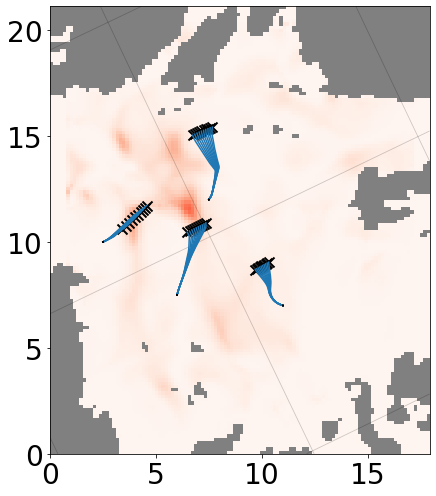

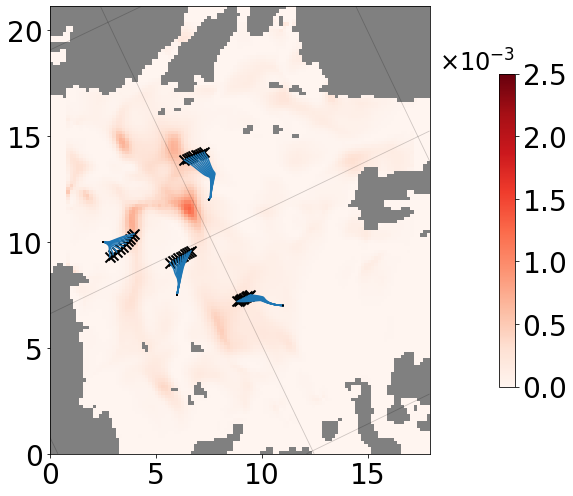

In [70]:
plot_drifters_and_variance(wind_stress_results, baroclinic_ref_sim, T, filename="wind_stress", vmax=0.0025, cbar=False)
plot_drifters_and_variance(wind_stress_results_no_windage, baroclinic_ref_sim, T, filename="wind_stress_nowindage", vmax=0.0025)

### Interface friction

In [71]:
friction_results = [None]*len(friction_samples)
friction_results_no_windage = [None]*len(friction_samples)
for i in range(len(friction_samples)):
    friction_results[i] = run_sample(ref_baroclinic_data_args, wind=ref_wind, wind_stress_factor=ref_wind_stress_factor, windage=ref_windage, friction=friction_samples[i])
    friction_results_no_windage[i] = run_sample(ref_baroclinic_data_args, wind=ref_wind, wind_stress_factor=ref_wind_stress_factor, windage=0, friction=friction_samples[i])



This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccura

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Maximum velocity:  0.3716409058000156 0.010050703271285499


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Maximum velocity:  0.3716409058000156 0.010050703271285499


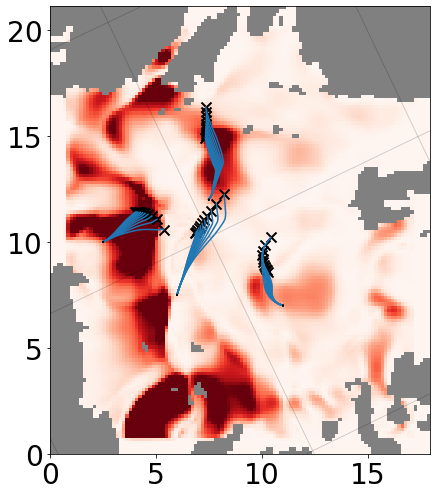

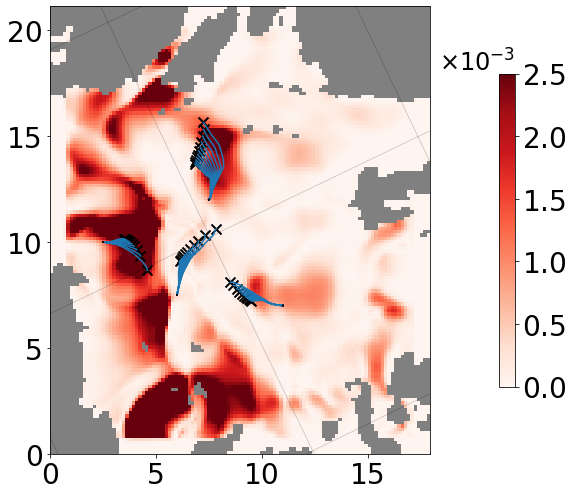

In [72]:
plot_drifters_and_variance(friction_results, baroclinic_ref_sim, T, filename="interface_friction", vmax=0.0025, cbar=False)
plot_drifters_and_variance(friction_results_no_windage, baroclinic_ref_sim, T, filename="interface_friction_nowindage", vmax=0.0025)

### Windage - wind contribution on advection

In [73]:
windage_results = [None]*len(windage_samples)
for i in range(len(windage_samples)):
    windage_results[i] = run_sample(ref_baroclinic_data_args, wind=ref_wind, wind_stress_factor=ref_wind_stress_factor, windage=windage_samples[i])


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccura

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Maximum velocity:  0.3716409058000156 2.7733391199176196e-32


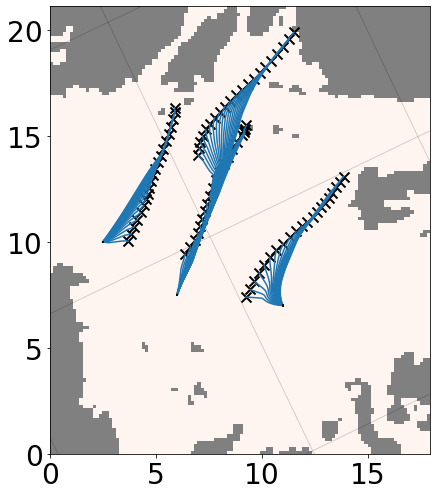

In [74]:
plot_drifters_and_variance(windage_results, baroclinic_ref_sim, T, filename="windage", cbar=False)

# Barotropic

### Wind direction

In [75]:
barotropic_wind_direction_results = [None]*len(wind_samples)
barotropic_wind_direction_results_no_windage = [None]*len(wind_samples)
for i in range(len(wind_samples)):
    barotropic_wind_direction_results[i] = run_sample(ref_barotropic_data_args, wind=wind_samples[i], wind_stress_factor=ref_wind_stress_factor, windage=ref_windage)
    barotropic_wind_direction_results_no_windage[i] = run_sample(ref_barotropic_data_args, wind=wind_samples[i], wind_stress_factor=ref_wind_stress_factor, windage=0)


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccura

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Maximum velocity:  0.24008958858701554 1.143568713174634e-07


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Maximum velocity:  0.24008958858701554 1.143568713174634e-07


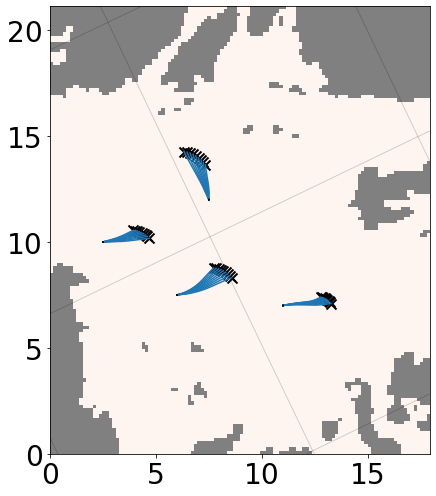

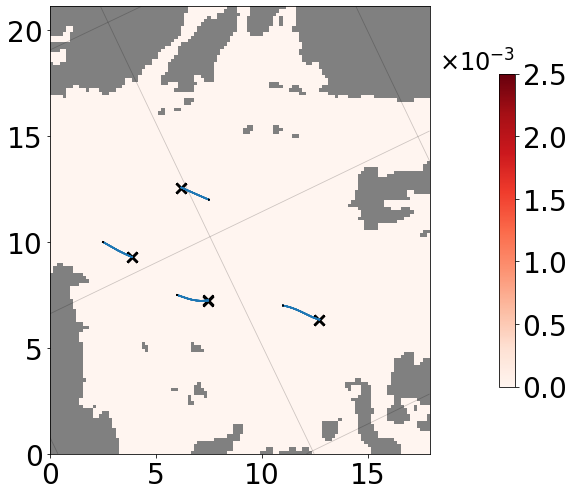

In [76]:
plot_drifters_and_variance(barotropic_wind_direction_results, barotropic_ref_sim, T, filename="wind_direction", vmax=0.0025, cbar=False)
plot_drifters_and_variance(barotropic_wind_direction_results_no_windage, barotropic_ref_sim, T, filename="wind_direction_nowindage", vmax=0.0025)


### Time shifted args

In [77]:
barotropic_time_shift_results = [None]*len(barotropic_time_shift_args)
barotropic_time_shift_results_no_windage = [None]*len(barotropic_time_shift_args)
for i in range(len(barotropic_time_shift_args)):
    barotropic_time_shift_results[i] = run_sample(barotropic_time_shift_args[i], wind=ref_wind, wind_stress_factor=ref_wind_stress_factor, windage=ref_windage)
    barotropic_time_shift_results_no_windage[i] = run_sample(barotropic_time_shift_args[i], wind=ref_wind, wind_stress_factor=ref_wind_stress_factor, windage=0)


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccura

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Maximum velocity:  0.2461070552831186 0.013259183503972807


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Maximum velocity:  0.2461070552831186 0.013259183503972807


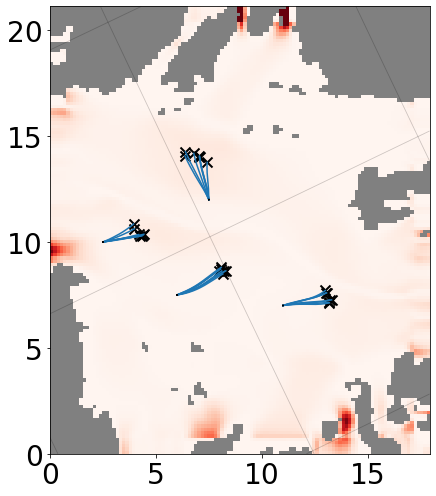

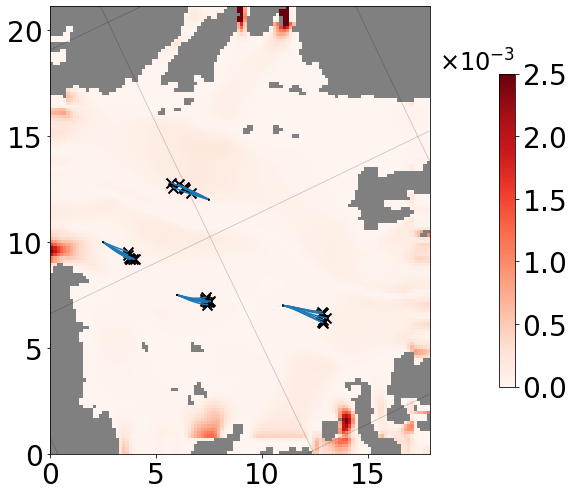

In [78]:
plot_drifters_and_variance(barotropic_time_shift_results, barotropic_ref_sim, T, filename="time_shifted_IC", vmax=0.0025, cbar=False)
plot_drifters_and_variance(barotropic_time_shift_results_no_windage, barotropic_ref_sim, T, filename="time_shifted_IC", vmax=0.0025)


### Time shifted wind

In [79]:
barotropic_wind_time_shift_results = [None]*len(barotropic_time_shift_args)
barotropic_wind_time_shift_results_no_windage = [None]*len(barotropic_time_shift_args)
for i in range(len(barotropic_time_shift_args)):
    barotropic_wind_time_shift_results[i] = run_sample(ref_barotropic_data_args, wind=barotropic_time_shift_args[i]["wind"], wind_stress_factor=ref_wind_stress_factor, windage=ref_windage)
    barotropic_wind_time_shift_results_no_windage[i] = run_sample(ref_barotropic_data_args, wind=barotropic_time_shift_args[i]["wind"], wind_stress_factor=ref_wind_stress_factor, windage=0)


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccura

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Maximum velocity:  0.24008958858701554 6.106884068867269e-08


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Maximum velocity:  0.24008958858701554 6.106884068867269e-08


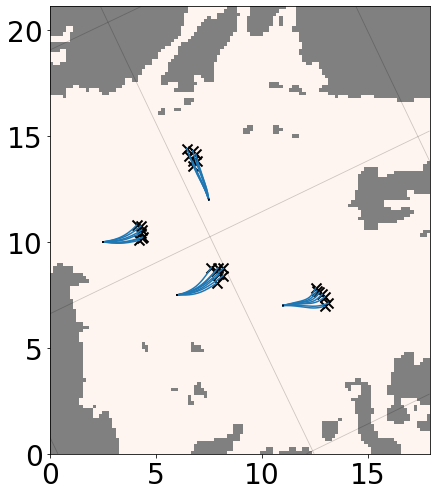

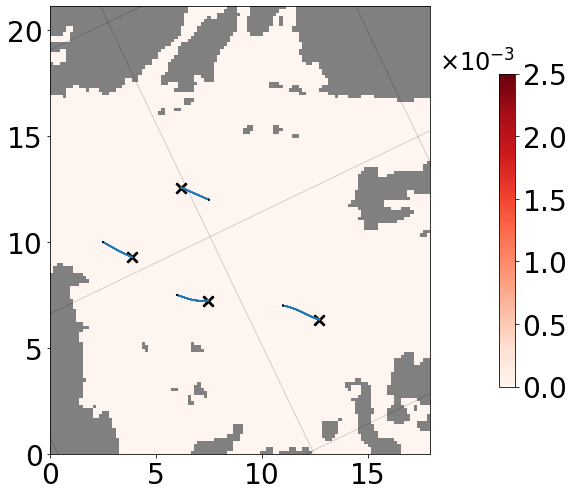

In [80]:
plot_drifters_and_variance(barotropic_wind_time_shift_results, barotropic_ref_sim, T, filename="time_shifted_wind", vmax=0.0025, cbar=False)
plot_drifters_and_variance(barotropic_wind_time_shift_results_no_windage, barotropic_ref_sim, T, filename="time_shifted_wind", vmax=0.0025)


### Bottom friction

In [81]:
barotropic_friction_results = [None]*len(friction_samples)
barotropic_friction_results_no_windage = [None]*len(friction_samples)
for i in range(len(friction_samples)):
    barotropic_friction_results[i] = run_sample(ref_barotropic_data_args, wind=ref_wind, wind_stress_factor=ref_wind_stress_factor, windage=ref_windage, friction=friction_samples[i])
    barotropic_friction_results_no_windage[i] = run_sample(ref_barotropic_data_args, wind=ref_wind, wind_stress_factor=ref_wind_stress_factor, windage=0, friction=friction_samples[i])



This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccura

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Maximum velocity:  5504.1388534533135 33.78433203739825


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


Maximum velocity:  5504.1388534533135 33.78433203739825


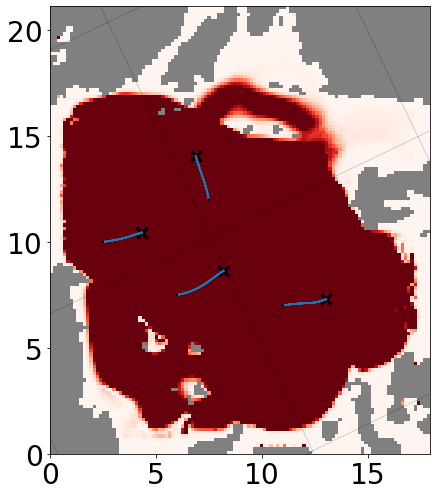

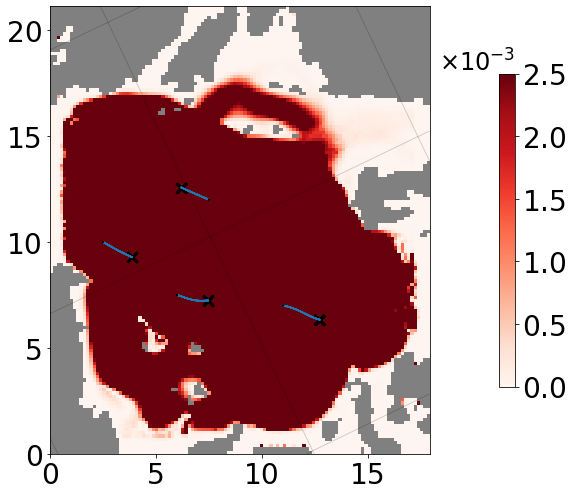

In [82]:
plot_drifters_and_variance(barotropic_friction_results, baroclinic_ref_sim, T, filename="barotropic_bottom_friction", vmax=0.0025, cbar=False)
plot_drifters_and_variance(barotropic_friction_results_no_windage, baroclinic_ref_sim, T, filename="barotropic_bottom_friction_nowindage", vmax=0.0025)

# Test filesize

In [83]:
def _plot_field_random(results, field, ref_sim, T, title=None, plot_trajectories=True, 
                cmap=plt.cm.Reds, vmin=0.0, vmax=0.5, filename=None, cbar=True, cbar_label=None, zoom=[0,None,0,None]):
    
    with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
        fig, ax = plt.subplots(1,1, figsize=(10,7))

        zoom_x0, zoom_x1, zoom_y0, zoom_y1 = zoom

        if zoom_x1 is None:
            dom_x1 = ref_sim.nx
        else:
            dom_x1 = zoom_x1
        if zoom_y1 is None:
            dom_y1 = ref_sim.ny
        else:
            dom_y1 = zoom_y1
        domain_extent = [zoom_x0*ref_sim.dx/1000, dom_x1*ref_sim.dx/1000, zoom_y0*ref_sim.dy/1000, dom_y1*ref_sim.dy/1000]

        cmap_cp = copy.copy(cmap)
        cmap_cp.set_bad("grey", alpha = 1.0)

        im = ax.imshow(field[zoom_y0:zoom_y1, zoom_x0:zoom_x1], interpolation="none", origin='lower', 
                       cmap=cmap_cp, 
                       vmin=vmin, vmax=vmax, 
                       extent=domain_extent, zorder=-5)

        ax.tick_params(axis='both', which='major', labelsize=28)

        if plot_trajectories:
            num_drifters = results[0]["trajectories"].get_num_drifters()
            num_results = len(results)
            extra_it = 20
            print("number of drift trajectories: " + str(extra_it*num_drifters*num_results))
            dummy_path = results[0]["trajectories"].get_drifter_path(0, 0, T, in_km = True)[0]
            X = np.zeros((dummy_path.shape[0], num_drifters*num_results*extra_it))
            Y = np.zeros((dummy_path.shape[0], num_drifters*num_results*extra_it))
            c = 0
            for d in range(num_drifters):
                for i in range(num_results):
                    orig_drifter_path = results[i]["trajectories"].get_drifter_path(d, 0, T, in_km = True)[0]
                    for extra in range(extra_it):
                        rand_walk = (np.random.rand(orig_drifter_path.shape[0], orig_drifter_path.shape[1]) - 0.5)*0.04
                        rand_walk = np.cumsum(rand_walk, axis=0)
                        drifter_path = orig_drifter_path + rand_walk
                        start_pos = drifter_path[0,:]

                        if (domain_extent[0] < start_pos[0] < domain_extent[1]) and (domain_extent[2] < start_pos[1] < domain_extent[3]):
                            circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                                            0.01, color = 'black',
                                                                            fill=True, zorder=6)
                            if i == 0 and extra == 0:
                                ax.add_patch(circ_start)

                            X[:, c] = drifter_path[:,0]
                            Y[:, c] = drifter_path[:,1]
                            
                            #ax.plot(drifter_path[:,0], drifter_path[:,1], color="C0", ls="-", zorder=5, rasterized=True)
                            #end_pos = drifter_path[-1,:]
                            #ax.scatter(end_pos[0], end_pos[1], marker='x', color='black', s=100, linewidths=2, rasterized=True)
                        c = c + 1
        ax.plot(X, Y, color="C0", ls="-", zorder=-3, alpha=0.3) #, rasterized=True)
        ax.scatter(X[-1,:], Y[-1, :], marker='x', color='black', s=100, linewidths=2, zorder=-4)# , rasterized=True)
        if cbar:
            cb = plt.colorbar(im, ax=ax, shrink=0.7, pad=0.1) #, shrink=0.8)
            cb.ax.tick_params(labelsize=28)
            cb.formatter.set_powerlimits((0, 0))
            cb.formatter.set_useMathText(True)
            cb.ax.yaxis.offsetText.set_fontsize(24)

        if cbar and cbar_label is not None:
            cb.set_label(label=cbar_label, size=36, labelpad=25)

        ax.contour(spec_lon, levels=spec_lon_levels, extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=2)
        ax.contour(spec_lat, levels=spec_lat_levels, extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=2)
        if title is not None:
            plt.title(title+"\n", fontsize=16)

        ax.set_rasterization_zorder(0)    
        plt.tight_layout()

        if filename is not None:
            folder = "boknafjord_sensitivity_figs"
            os.makedirs(folder, exist_ok=True)
            plt.savefig(os.path.join(folder, filename+".pdf"), bbox_inches="tight", dpi=400)

number of drift trajectories: 1360


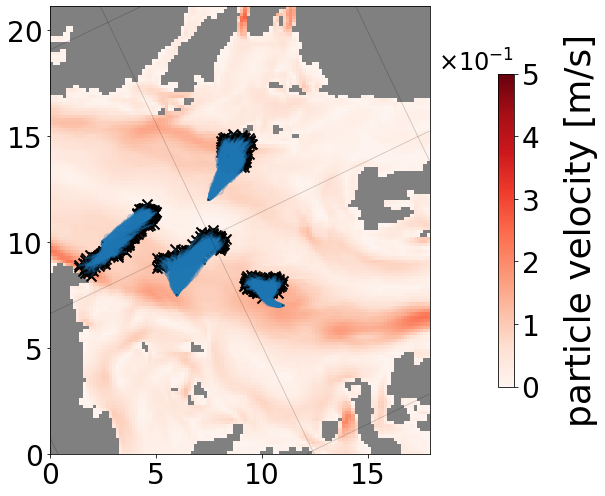

In [84]:
_plot_field_random(mld_dens_results_no_wind, initV, baroclinic_ref_sim, T, filename="testing_file_size_raster_z0", plot_trajectories=True, cbar_label="particle velocity [m/s]")

In [85]:
T

21600

In [100]:
drifter_path = windage_results[i]["trajectories"].get_drifter_path(d, 0, T, in_km = True)[0]
rand_walk = np.random.rand(drifter_path.shape[0], drifter_path.shape[1])*0.05 - 0.0025
print(rand_walk.shape)
rand_walk = np.cumsum(rand_walk, axis=0)
print(rand_walk.shape)
print(rand_walk[:10,:])
drifter_path + rand_walk

(181, 2)
(181, 2)
[[0.04538935 0.01981965]
 [0.0520737  0.02942359]
 [0.08898502 0.05096968]
 [0.09679488 0.05917597]
 [0.09782343 0.10443449]
 [0.10668046 0.12189956]
 [0.12739981 0.12125219]
 [0.15846763 0.1199171 ]
 [0.19906451 0.14759529]
 [0.21236562 0.17724649]]


array([[ 7.54538935, 12.01981965],
       [ 7.57277243, 12.06349097],
       [ 7.62908853, 12.11694331],
       [ 7.65553707, 12.15638886],
       [ 7.67498017, 12.23304387],
       [ 7.70199345, 12.28206265],
       [ 7.74051163, 12.31305102],
       [ 7.78902231, 12.34361534],
       [ 7.84665826, 12.40330134],
       [ 7.87631924, 12.46499551],
       [ 7.92931598, 12.53707622],
       [ 7.99054988, 12.58955747],
       [ 8.03751398, 12.63665872],
       [ 8.09878859, 12.70140049],
       [ 8.11860938, 12.77825651],
       [ 8.14577838, 12.84374762],
       [ 8.16474348, 12.89511333],
       [ 8.19890074, 12.93348873],
       [ 8.22625961, 12.97594364],
       [ 8.27504276, 13.04984596],
       [ 8.31156337, 13.08982419],
       [ 8.33884617, 13.15814975],
       [ 8.35597017, 13.19765806],
       [ 8.38719164, 13.23477194],
       [ 8.44580621, 13.29122709],
       [ 8.50309501, 13.36122685],
       [ 8.51256644, 13.42284798],
       [ 8.54329491, 13.50092336],
       [ 8.5959823 ,